In [40]:
# pip install dash==0.42.0

from itertools import cycle

import numpy as np
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import matplotlib.pyplot as plt
import scipy as sp
from scipy import special
from scipy import interp

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import classification_report
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

from imblearn.metrics import classification_report_imbalanced

%matplotlib inline

In [41]:
def generate_data(class_sizes: list = None, means_iterator=None):
    """
    Generates data 
    input list of integers. Each element corresponds to a class and its size
    i.e. [100, 50, 200] corresponds to a dataset with 100 datapoints in class 1, 50 in class 2, and 200 in class 3
    
    ADD BATCHES
    returns pre_softmax, softmaxed, predictions, labels
    """
    iteratate_means = False

    if means_iterator != None:
        iteratate_means = True
        means_iterator = iter(means_iterator)
        
    if class_sizes == None:
        class_sizes = np.asarray([10000, 10000])
    
    pre_softmax = np.empty(0)
    labels = np.empty(0)
    
    for i, class_ in enumerate(class_sizes):
        
        labels = np.append(labels, np.full(class_, i))
        to_stack_ = np.empty(0)
        for class_index in range(len(class_sizes)):
            
            if iteratate_means:
                sampling_mean = next(means_iterator)

            elif i == class_index:
                sampling_mean = 0.6
            else:
                sampling_mean = 0.4
                
            if to_stack_.size == 0:
                to_stack_ = np.random.normal(loc=sampling_mean, scale=.1, size=class_)
                to_stack_ = np.expand_dims(to_stack_, 1)
            else:
                temp_ = np.random.normal(loc=sampling_mean, scale=.1, size=class_)
                temp_ = np.expand_dims(temp_, 1)
                
                to_stack_ = np.concatenate((to_stack_, temp_), axis=1)

        if pre_softmax.size == 0:
            pre_softmax = to_stack_
        else:
            pre_softmax = np.concatenate((pre_softmax, to_stack_))
         
    softmaxed = special.softmax(pre_softmax, axis=1)
    predictions = np.argmax(softmaxed, axis=1)
    predictions = predictions.astype(int)
    labels = labels.astype(int)
    
    return (pre_softmax, softmaxed, predictions, labels)

def multi_class_roc(data_sizes, sampling_means=None):
    
    n_classes = len(data_sizes)
    pre_softmax, y_score, predictions, labels = generate_data(data_sizes, sampling_means)
    
    y_test = label_binarize(labels, classes=list(range(len(data_sizes))))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    ax = plt.gca()
    bruno_markers(ax)
    plt.show()
    
    return y_score, predictions, labels

def bruno_markers(ax):
    ax.plot(.2, .9, marker="1")
    ax.plot(.1, .5, marker="2")
    ax.plot(.5, .9, marker="3")

# Metrics in machine learning

*When a measure becomes a target, it ceases to be a good measure*

### Brief journey of data through a model

A single datum is sent through a model. 
For each class (k), the model produces values. e.g. [0.2, 0.8, 2.0]
These values are not normalized and will therefore not sum to one. In neural networks we achieve this through softmax, which results in [0.11, 0.21, 0.68]. These are often called the **activations** or the **scores**. 

When we are training neural networks a **loss** will be calculated. This is dependent on the True class of the input datum. 
In this case the True class corresponded with the prediction! You can calculate loss in different ways. Here is a simple example loss: True class is the third index then the loss is 1 - 0.68 = 0.32. If the True class was the second index the loss would be 1 - 0.21 = 079; and the first index it would be 1 - 0.11 = 0.89. (p.s. usually you take the negative log of these values)

**Loss** is a term used for training a model. It represents how 'off' a model is from perfection for the sample. In this example, a perfect model should output [0, 0, 1] if the true label is [0, 0, 1]. Anything short of that incurs a loss. 


Loss is a metric which we often only look at to see whether the model is training correctly. For evaluating models we use other metrics. It is important to note that during training models are optimized on loss* while we evaluate on other metrics. 



**note that during hyperparameter optimization (i.e. cross validation) we use AUROC as an optimization metric.* 


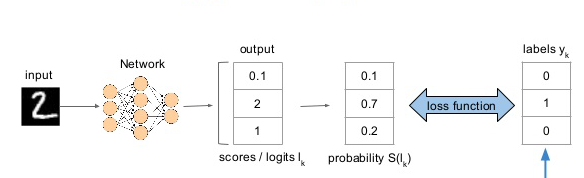

#### Brief notice on the use of classification models...

Classification models are tasked at classifying. Therefore they are not explicitly trained to know anything about the actual data distribution (green).

Instead they look for the disciminator lines (red)

This should always be in the back of our mind when interpreting results, especially in the context of uncertainty estimation!

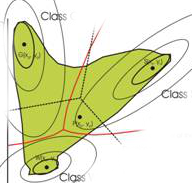

## From Score to metrics: Two different ideas

### 1: Using Predictions to get metrics

Usually the model then chooses the highest score as its prediction. In this case the last class is chosen. [0.11, 0.21, 0.68]. The **prediction** would therefore be [0, 0, 1], identical to the **label** [0, 0, 1]! This makes this datapoint a **True Positive (TP)** for the third class and for the first and second class these are classified as **True Negatives (TN)**. If it had predicted class two it would have been a **False Negative (FN)** for class three, a **False Positive (FP)** for class two and a **True Negatives (TN)** for class one. 

To sum, to determine whether or not something is either TP/TN/FP/FN you need to be aware of which class is being attended to. 

Each class will therefore have their own set of TP/TN/FP/FN values. 

See the image below for an example

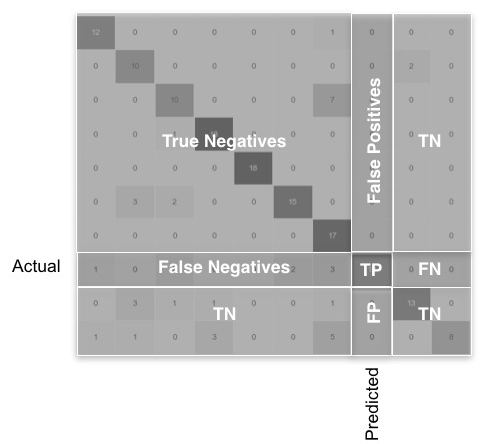

*Image from https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py*

Using the max score to determine the **TP/TN/FP/FN** is the most common method. Using a confusion matrix is the best way to see these values. 

With these metrics we can easilly generate more complex metrics such as **Accuracy**, **Precision**, **Recall (sensitivity)**, ***sensiticity*, **F1**, **Weighted Accuracy**, **Rand Index**, **MCC**, **Kappa**


For machine learning we often use precision, recall, F1 and accuracy. Basically the output of an sklearn classification report. 





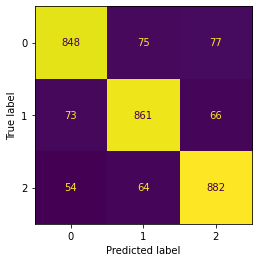

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.86      0.86      0.86      1000
           2       0.86      0.88      0.87      1000

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



In [67]:
_, activations, predictions, labels = generate_data([1000, 1000, 1000])

cm = confusion_matrix(labels, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot(colorbar=None)
plt.show()

print(classification_report(labels, predictions))


# MCC = matthews_corrcoef(labels, predictions)
# kappa = cohen_kappa_score(labels, predictions)


# print(f"MCC: {MCC}\nkappa: {kappa}")




### 2: Using thresholds and AUROC/AUPRC

Using the max value to determine the prediction is not the only method. One can also use thresholds. 

A threshold sets a clear boundary where anything greater than the threshold is a **Positive Prediction** to the class and anything under the threshold is a **Negative Prediction**. This can be seen on the leftmost graph.

These predictions are then categorized as either **False** or **True**. I.e. False Positives, False Negatives, True Negatives, False Negatives. depending on the labels, see the middle graph, blue has the **Positive Label** and orange has the **Negative Label**. 

Note that the False class encompasses all other classes (Green and orange), see the rightmost graph. In this way a binary classification system is generalized to a multiclass problem. 

Note: This is performed PER CLASS. Therefore, three ROCs will be generated. 

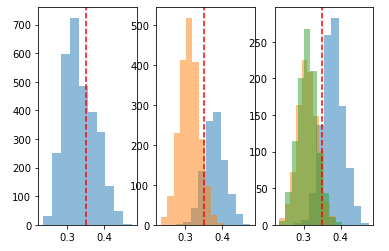

In this way it is possible to generate **TP/TN/FP/FN** values at every threshold for every class. With these we can calculate other metrics.

### AUROC

For AUROC we use **True Positive Rate (TPR)** and **False Positive Rate (FPR)**

$TPR = \frac{TP}{TP+FN}$

The **TPR** is also known as **Recall** or **Sensitivity**

<br><br><br>

$FPR = \frac{FP}{FP+TN}$

The **FPR** is also **1 - True Negative Rate (TNR)**.
The **TNR** is also known as **Specificity** or **Selectivity**

This is important to be aware of when trying to achieve targets such as **Sensitivity of 90%** and **Specificity of 80%**

### AUPRC

For AUPRC we use **Precision** and **Recall**

$Precision = \frac{TP}{TP+FP}$

See https://en.wikipedia.org/wiki/Confusion_matrix for reference.



NOTE: **"Precision and Recall"** are completely different from **"Accuracy and Precision"**. Learning data science is similar to learning a new language. There are many synonyms and homonyms.

https://en.wikipedia.org/wiki/Precision_and_recall

https://en.wikipedia.org/wiki/Accuracy_and_precision

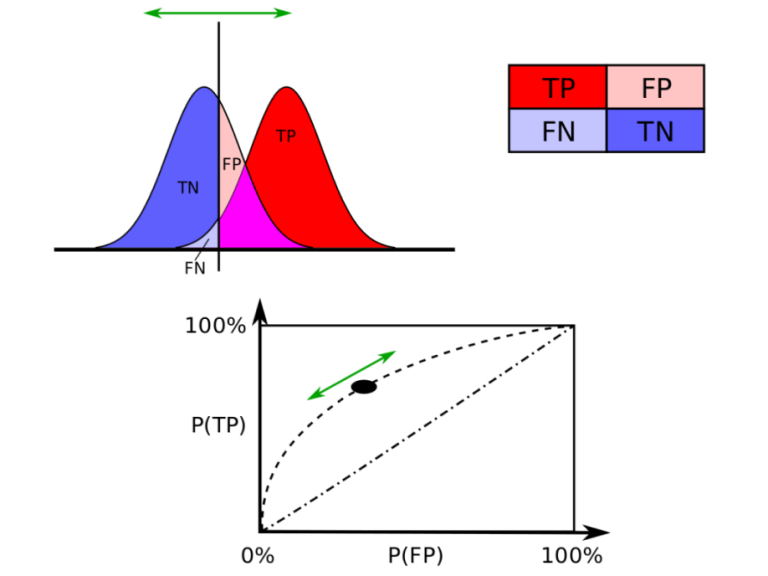

*Image from wikipedia*

### Let's run some code!

Scores
[[0.33990445 0.37655207 0.28354348]
 [0.34568838 0.31712121 0.33719042]
 [0.4001673  0.2900446  0.3097881 ]
 [0.316866   0.34196198 0.34117201]
 [0.35858022 0.30824106 0.33317872]]

predictions
[1 0 0 1 0] 

True labels
[0 0 0 0 0]


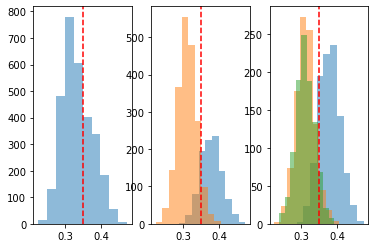

In [68]:
_, softmaxed, predictions, labels = generate_data([1000, 1000, 1000])

# print(pre_softmax.shape, softmaxed.shape, predictions.shape, labels.shape)
# print(f"pre_softmax:\n{pre_softmax[:5]} \n\nsoftmaxed\n{softmaxed[:5]}\n\npredictions\n{predictions[:5]} \n\nTrue labels\n{labels[:5]}")
print(f"Scores\n{softmaxed[:5]}\n\npredictions\n{predictions[:5]} \n\nTrue labels\n{labels[:5]}")


fig, axs = plt.subplots(1, 3, sharex=True)

axs[0].hist(softmaxed[:, 0], bins=10, alpha=.5)
axs[0].axvline(x=0.35,ls="--",c="r")

axs[1].hist(softmaxed[labels==0, 0], bins=10, alpha=.5)
axs[1].hist(softmaxed[labels!=0, 0], bins=10, alpha=.5)
axs[1].axvline(x=0.35,ls="--",c="r")

axs[2].hist(softmaxed[labels==0, 0], bins=10, alpha=.5)
axs[2].hist(softmaxed[labels==1, 0], bins=10, alpha=.5)
axs[2].hist(softmaxed[labels==2, 0], bins=10, alpha=.5)
axs[2].axvline(x=0.35,ls="--",c="r")

plt.show()


### Multiclass AUROC

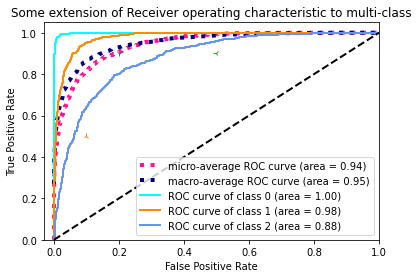

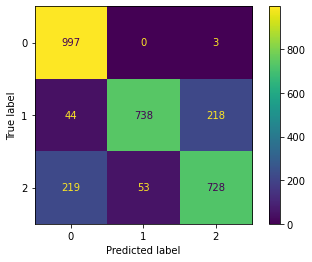

In [49]:
data_sizes = [1000, 1000, 1000]
sampling_means = [0.8, 0.2, 0.4, 
                  0.6, 0.8, 0.7, 
                  0.7, 0.6, 0.8]

_, predictions, labels = multi_class_roc(data_sizes, sampling_means)

cm = confusion_matrix(labels, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap = "viridis")
plt.show()

## Unbalanced data

    *Unbalanced, but unbiased!*
    

As long as your model predicts unbalanced data correctly, the effect is not noticeable at all in AUROC curves. However that is not the case in AUPRC curves.

That being said. Unbalanced data often induces bias into the model and it's often better to avoid this.

Unbalanced Data
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1000
           1       0.57      0.95      0.71       100

    accuracy                           0.93      1100
   macro avg       0.78      0.94      0.84      1100
weighted avg       0.96      0.93      0.94      1100

MCC: 0.706
kappa: 0.678
Balanced Accuracy: 0.94


Balanced Data
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1000
           1       0.93      0.92      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

MCC: 0.857
kappa: 0.857
Balanced Accuracy: 0.929


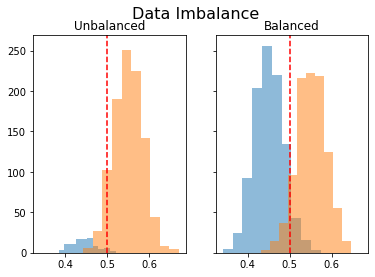

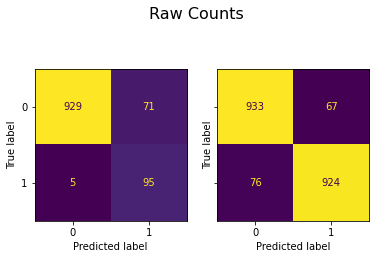

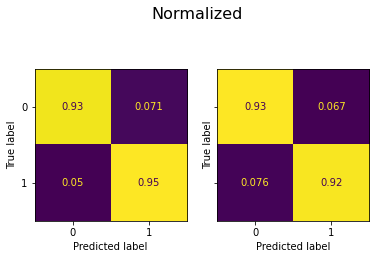

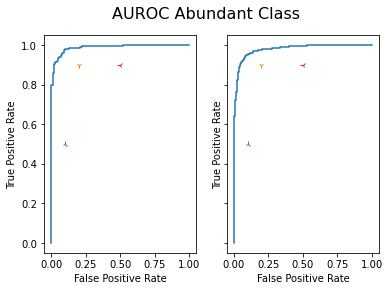

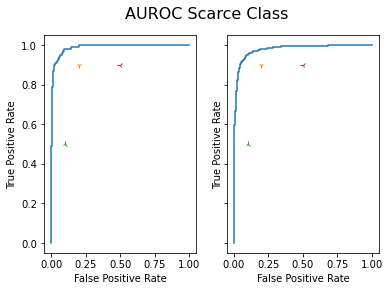

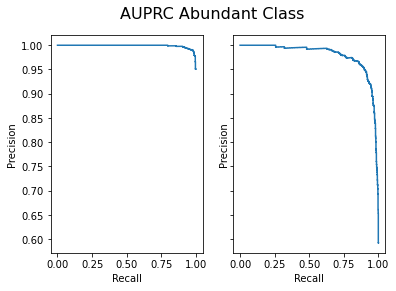

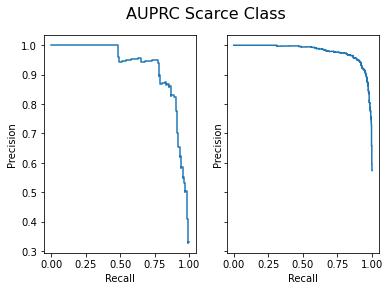

In [69]:
data_sizes = [1000, 100]
data_sizes2 = [1000, 1000]

_, softmaxed, predictions, labels = generate_data(data_sizes)
_, softmaxed2, predictions2, labels2 = generate_data(data_sizes2)

threshold = 0.5

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Data Imbalance', fontsize=16)
axs[0].hist(softmaxed[labels==1.0, 0], bins=10, alpha=.5)
axs[0].hist(softmaxed[labels==0.0, 0], bins=10, alpha=.5)
axs[0].axvline(x=threshold, ls="--", c="r")
axs[0].set_title('Unbalanced')

axs[1].hist(softmaxed2[labels2==1.0, 0], bins=10, alpha=.5)
axs[1].hist(softmaxed2[labels2==0.0, 0], bins=10, alpha=.5)
axs[1].axvline(x=threshold,ls="--",c="r")
axs[1].set_title('Balanced')

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Raw Counts', fontsize=16)
cm = confusion_matrix(labels, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[0], colorbar=False)
cm = confusion_matrix(labels2, predictions2)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[1], colorbar=False)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Normalized', fontsize=16)
cm = confusion_matrix(labels, predictions, normalize="true")
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[0], colorbar=False)
cm = confusion_matrix(labels2, predictions2, normalize="true")
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[1], colorbar=False)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('AUROC Abundant Class', fontsize=16)

fpr, tpr, _ = roc_curve(labels, softmaxed[:, 0], pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[0])
bruno_markers(axs[0])
fpr, tpr, _ = roc_curve(labels2, softmaxed2[:, 0], pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[1])
bruno_markers(axs[1])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('AUROC Scarce Class', fontsize=16)

fpr, tpr, _ = roc_curve(labels, softmaxed[:, 1], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[0])
bruno_markers(axs[0])
fpr, tpr, _ = roc_curve(labels2, softmaxed2[:, 1], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[1])
bruno_markers(axs[1])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('AUPRC Abundant Class', fontsize=16)

prec, recall, _ = precision_recall_curve(labels, softmaxed[:, 0], pos_label=0)
roc_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axs[0])
prec, recall, _ = precision_recall_curve(labels2, softmaxed2[:, 0], pos_label=0)
roc_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axs[1])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('AUPRC Scarce Class', fontsize=16)

prec, recall, _ = precision_recall_curve(labels, softmaxed[:, 1], pos_label=1)
roc_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axs[0])
prec, recall, _ = precision_recall_curve(labels2, softmaxed2[:, 1], pos_label=1)
roc_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axs[1])


MCC = matthews_corrcoef(labels, predictions)
kappa = cohen_kappa_score(labels, predictions)
bal_acc = balanced_accuracy_score(labels, predictions)
acc = accuracy_score(labels, predictions)

print("Unbalanced Data")
print(classification_report(labels, predictions))
print(f"MCC: {MCC:.3}\nkappa: {kappa:.3}\nBalanced Accuracy: {bal_acc:.3}")

# print("\n\n")

# print(classification_report_imbalanced(labels, predictions))

print("\n\nBalanced Data")
MCC = matthews_corrcoef(labels2, predictions2)
kappa = cohen_kappa_score(labels2, predictions2)
bal_acc = balanced_accuracy_score(labels2, predictions2)
acc = accuracy_score(labels2, predictions2)
print(classification_report(labels2, predictions2))
print(f"MCC: {MCC:.3}\nkappa: {kappa:.3}\nBalanced Accuracy: {bal_acc:.3}")

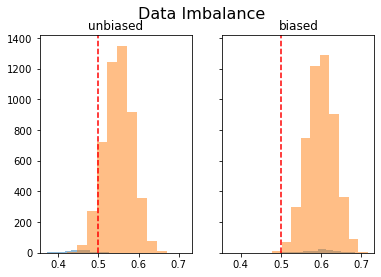

Unbalanced Data but unbiased
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      5000
           1       0.19      0.94      0.32       100

    accuracy                           0.92      5100
   macro avg       0.60      0.93      0.64      5100
weighted avg       0.98      0.92      0.95      5100

MCC: 0.407
kappa: 0.299
Balanced Accuracy: 0.931




Unbalanced Data and biased
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5000
           1       0.00      0.00      0.00       100

    accuracy                           0.98      5100
   macro avg       0.49      0.50      0.49      5100
weighted avg       0.96      0.98      0.97      5100

MCC: -0.00595
kappa: -0.00325
Balanced Accuracy: 0.499


In [53]:
data_sizes = [5000, 100]
data_sizes2 = [5000, 100]
data_means2 = [.8, 0.4,
               .8, 0.4]


_, softmaxed, predictions, labels = generate_data(data_sizes)
_, softmaxed2, predictions2, labels2 = generate_data(data_sizes2, data_means2)

threshold = 0.5

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Data Imbalance', fontsize=16)
axs[0].hist(softmaxed[labels==1.0, 0], bins=10, alpha=.5)
axs[0].hist(softmaxed[labels==0.0, 0], bins=10, alpha=.5)
axs[0].axvline(x=threshold, ls="--", c="r")
axs[0].set_title('unbiased')

axs[1].hist(softmaxed2[labels2==1.0, 0], bins=10, alpha=.5)
axs[1].hist(softmaxed2[labels2==0.0, 0], bins=10, alpha=.5)
axs[1].axvline(x=threshold,ls="--",c="r")
axs[1].set_title('biased')

plt.show()

MCC = matthews_corrcoef(labels, predictions)
kappa = cohen_kappa_score(labels, predictions)
bal_acc = balanced_accuracy_score(labels, predictions)

print("Unbalanced Data but unbiased")
print(classification_report(labels, predictions))
print(f"MCC: {MCC:.3}\nkappa: {kappa:.3}\nBalanced Accuracy: {bal_acc:.3}")

print("\n\n\n")

MCC = matthews_corrcoef(labels2, predictions2)
kappa = cohen_kappa_score(labels2, predictions2)
bal_acc = balanced_accuracy_score(labels2, predictions2)

print("Unbalanced Data and biased")
print(classification_report(labels2, predictions2))
print(f"MCC: {MCC:.3}\nkappa: {kappa:.3}\nBalanced Accuracy: {bal_acc:.3}")

What is happening here?

Data imbalance is a serious issue in machine learning. If a dataset is imbalanced the model can simply predict a single class without much repurcussion. For example, if a dataset contains the negative class in 95% of the cases, a model predicting negative for all datapoints would have an accuracy of 95%!

In order to mitigate this several metrics are used. These also include AUROC and AUPRC. The whole metrics field aims to find methods to capture the relation between the model performance and the data. 

#### Kappa

Kappa directly tried to combat imbalance by introducing expectations. Intuitively it makes sense that if a dataset contains 95% negative cases, then intuitively it would be fair to expect that the classifier has at least 95% accuracy. 


Accuracy = $\frac{TP + TN}{Total}$

PosTerm = $\frac{(TP+FN)(TP+FP)}{Total}$

NegTerm = $\frac{(TN+FP)(TN+FN)}{Total}$

ExpectedAcc = $\frac{Pos Term + Neg Term}{Total}$

Kappa = $\frac{Accuracy - ExpectedAcc}{1 - ExpectedAcc}$



#### MCC

MCC = $\frac{TP * TN - FP * FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$

So, what's the intuition behind this?

That is a very good question. If you look at the MCC you can perhaps see that it looks very similar to Accuracy. Except that it uses all 4 parts of the confusion matrix. Somehow this makes this metric more encompassing when it comes to the effect of FP and FN. This leads to the metric reflecting the negative effects of unbalanced data much better. 

Accuracy = $\frac{TP + TN}{(TP+FP+TN+FN}$

## Batch Effect 
    *- Biased Data*

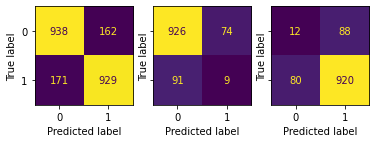

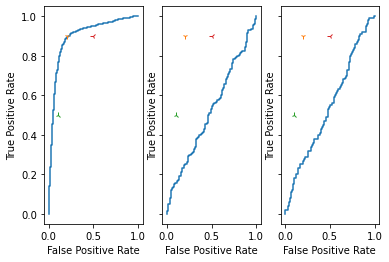

Total Data
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1100
           1       0.85      0.84      0.85      1100

    accuracy                           0.85      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.85      0.85      0.85      2200

MCC: 0.697
kappa: 0.697
Balanced Accuracy: 0.849


Batch 1
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.11      0.09      0.10       100

    accuracy                           0.85      1100
   macro avg       0.51      0.51      0.51      1100
weighted avg       0.84      0.85      0.84      1100

MCC: 0.0174
kappa: 0.0173
Balanced Accuracy: 0.508


Batch 2
              precision    recall  f1-score   support

           0       0.13      0.12      0.12       100
           1       0.91      0.92      0.92      1000

    accuracy                           0.85      11

In [70]:
bias_positive = 0.8
bias_negative = 0.6

_, softmaxed1, predictions1, labels1 = generate_data([1000, 100], [bias_positive, bias_negative, bias_positive, bias_negative])
_, softmaxed2, predictions2, labels2 = generate_data([100, 1000], [bias_negative, bias_positive, bias_negative, bias_positive])

predictions = np.asarray([*predictions1, *predictions2])
labels = np.asarray([*labels1, *labels2])
softmaxed = np.asarray([*softmaxed1, *softmaxed2])


fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

cm = confusion_matrix(labels, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[0], colorbar=None)

cm = confusion_matrix(labels1, predictions1)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[1], colorbar=None)

cm = confusion_matrix(labels2, predictions2)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[2], colorbar=None)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

fpr, tpr, _ = roc_curve(labels, softmaxed[:, 0], pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[0])
bruno_markers(axs[0])

fpr, tpr, _ = roc_curve(labels1, softmaxed1[:, 0], pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[1])
bruno_markers(axs[1])

fpr, tpr, _ = roc_curve(labels2, softmaxed2[:, 0], pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[2])
bruno_markers(axs[2])

plt.show()

print("Total Data")
MCC = matthews_corrcoef(labels, predictions)
kappa = cohen_kappa_score(labels, predictions)
bal_acc = balanced_accuracy_score(labels, predictions)
print(classification_report(labels, predictions))
print(f"MCC: {MCC:.3}\nkappa: {kappa:.3}\nBalanced Accuracy: {bal_acc:.3}")

print("\n\nBatch 1")
MCC = matthews_corrcoef(labels1, predictions1)
kappa = cohen_kappa_score(labels1, predictions1)
bal_acc = balanced_accuracy_score(labels1, predictions1)
print(classification_report(labels1, predictions1))
print(f"MCC: {MCC:.3}\nkappa: {kappa:.3}\nBalanced Accuracy: {bal_acc:.3}")

print("\n\nBatch 2")
MCC = matthews_corrcoef(labels2, predictions2)
kappa = cohen_kappa_score(labels2, predictions2)
bal_acc = balanced_accuracy_score(labels2, predictions2)
print(classification_report(labels2, predictions2))
print(f"MCC: {MCC:.3}\nkappa: {kappa:.3}\nBalanced Accuracy: {bal_acc:.3}")

## Confusion paradox: strange AUROC behaviors! 

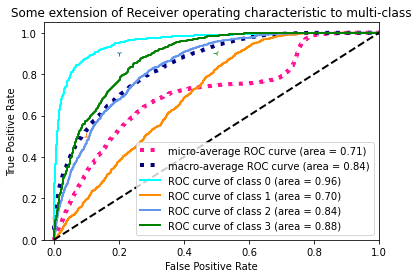

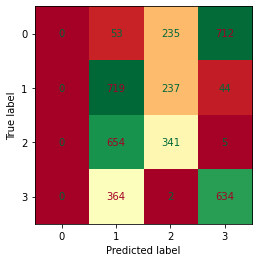

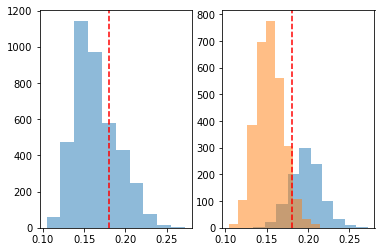

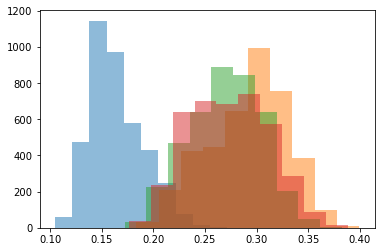

Scores
[[0.18503577 0.21721296 0.28658113 0.31117013]
 [0.20216447 0.23252123 0.26225644 0.30305786]
 [0.20617516 0.23812592 0.28732944 0.26836949]
 [0.16084547 0.25873257 0.30792313 0.27249882]
 [0.21447641 0.27281638 0.23122663 0.28148058]]

predictions
[3 3 2 2 3] 

True labels
[0 0 0 0 0]


In [24]:
data_sizes = [1000, 1000, 1000, 1000]

sampling_means = [0.3, 0.5, 0.6, 0.7,
                  0.05, 0.8, 0.7, 0.6,
                  0.05, 0.8, 0.75, 0.5,
                  0.05, 0.65, 0.4, 0.7]


y_score, predictions, labels = multi_class_roc(data_sizes, sampling_means)


cm = confusion_matrix(labels, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap = "RdYlGn", colorbar=None)

fig, axs = plt.subplots(1, 2, sharex=True)

axs[0].hist(y_score[:, 0], bins=10, alpha=.5)
axs[0].axvline(x=0.18,ls="--",c="r")

axs[1].hist(y_score[labels==0, 0], bins=10, alpha=.5)
axs[1].hist(y_score[labels!=0, 0], bins=10, alpha=.5)
axs[1].axvline(x=0.18,ls="--",c="r")

plt.show()

fig, axs = plt.subplots(1, 1, sharex=True)

axs.hist(y_score[:, 0], bins=10, alpha=.5)
axs.hist(y_score[:, 1], bins=10, alpha=.5)
axs.hist(y_score[:, 2], bins=10, alpha=.5)
axs.hist(y_score[:, 3], bins=10, alpha=.5)
plt.show()

print(f"Scores\n{y_score[:5]}\n\npredictions\n{predictions[:5]} \n\nTrue labels\n{labels[:5]}")

#### Conclusion

Try not to use ROC for multi-class. The biases of the metric become more pronounced. 

## Bias! What to do

What can we do against this?

### Selective sampling, Weighted Loss

During training of the models there are only a few options at hand. The most preferred is to just have data which captures the variance of the data. This often translates to more data as there are so many sources of variance. (Gender, Batch, Machine, Features, Diagnosis, The weather, etc. etc.)

Another option is to manually enforce the data balance. This can be done either through selective sampling or weighted losses. Weighted losses has the advantage in that it still uses the original data.

Lastly, we can attempt to reduce variance in the data. For example, removing batch effect through compression (autoencoders) or through explicity debiasing.

### Training outside training (i.e. hyperparameter optimization)

Metrics can help elucidate these biases. When doing hyperparameter optimization we can use a metric which specifically adresses data imbalance and bias caused by this.

For example, grouping the data by batch and calculating the MCC/Kappa score for each batch. Then take the average (or weighted average) of those batches.




## Clustering!

TODO

Methodology for batch removal

    -Use methods on data to attempt to remove batches
    -Check whether the batch effect is still present

Checking whether batch effect is present:

comparing performance before and after removal method

    -Use an unsupervised clustering method like KNN and see how well they 'fit' with the batches. The better the fit, the worse
    
    -Use an explicit model to try to find the batch effects. If they are able to predict batch effect better, the worse.
    
    

## Uncertainty estimation!

TODO

    -just look at the scores! (this is joke btw)
    -bootstrapping, using multiple replicates of the same datum
    -just use dropout!
    -ensemble of models
    -bayesian stuff

In [12]:




# Accuracy, specificity, sensitivity, precision, F1, IBA, MCC, Kappa, Rand index,

# reconstruction loss - L1, KL divergence, Jensenn-Shannon
# LR
# Geometric mean (on what?), (index) balanced accuracy, supremum

# Goals:
# Machine learning -> Accuracy, F1, precision + recall, confusion matrices, AUROC, AUPRC
# Biology? Stats? stuff? Diagnostic ratios (and relation to log) (bruno goals stuff, and how we can modify our models to focus on one or the other)
# Odds ratio, 
# Clustering metrics! (unsupervised stuff / kinda)
# 
# rand index, kappa, IBA
# multi-class stuff, but it's even more complex with multi-label!

# 
# VAE, reconstruction loss, KL-divergence



# models, clustering, bio stuff, multi class

In [13]:
# Load Data
df = px.data.tips()# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )# Run app and display result inline in the notebook
app.run_server(mode='inline')

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8050): Max retries exceeded with url: /_alive_6a078f30-955f-431e-b370-188854ecae78 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f85e8fe6520>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

_, activations, predictions, labels = generate_data([1000, 1000])

y_score = activations[:, 1]
y = labels

fpr, tpr, thresholds = roc_curve(y, y_score)

# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=y_score, color=y, nbins=50, opacity=0.5, barmode='overlay',
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/mah/opt/anaconda3/envs/test/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/Users/mah/opt/anaconda3/envs/test/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mah/opt/anaconda3/envs/test/lib/python3.9/site-packages/retrying.py", line 49, in wrapped_f
    return Retrying(*dargs, **dkw).call(f, *args, **kw)
  File "/Users/mah/opt/anaconda3/envs/test/lib/python3.9/site-packages/retrying.py", line 212, in call
    raise attempt.get()
  File "/Users/mah/opt/anaconda3/envs/test/lib/python3.9/site-packages/retrying.py", line 247, in get
    six.reraise(self.value[0], self.value[1], self.value[2])
  File "/Users/mah/opt/anaconda3/envs/test/lib/python3.9/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/mah/opt/anaconda3/envs/test/lib/python3.9/site-packages/retrying.py", line 200, in call
    attemp